In [1]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import special
from scipy import optimize
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import cm, image

import seaborn as sns
import plotly as py
import plotly.express as px
from datetime import date
from glob import glob
from os.path import join, dirname
import random
from random import random as rand

from tqdm import tqdm

import pingouin as pg

In [2]:
%config InlineBackend.figure_format = 'retina'
py.offline.init_notebook_mode(connected = True)

In [3]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

---

In [4]:
dir_result = '/home/sungbeenpark/Github/labs/GL/results'

dir_root = '/mnt/ext4/GL'
dir_behav = join(dir_root,'behav_data')
dir_fmri = join(dir_root,'fmri_data')

In [5]:
list_subj = []
for dname in glob(join(dir_fmri,'preproc_data.SSKim/GL??')):
    subj = dname[-4:]
    list_subj.append(subj)
list_subj = np.array(sorted(list_subj))
list_subj

array(['GL03', 'GL04', 'GL05', 'GL06', 'GL07', 'GL08', 'GL09', 'GL10',
       'GL11', 'GL12', 'GL14', 'GL15', 'GL16', 'GL17', 'GL18', 'GL19',
       'GL20', 'GL21', 'GL22', 'GL24', 'GL25', 'GL26', 'GL27', 'GL29'],
      dtype='<U4')

---

In [6]:
spt = 4  ## time spend(second) in each trial
ntrials = 12 ## the number of trials per block
nblocks = 12 ## the number of blocks per RUN
nruns = 6 ## main (on/off): 4 runs / test: 2 runs

---

In [7]:
def convert_ID(ID):
    ##################   ##################
    #  1  2  3  4  5 #   #        2       #
    #  6  7  8  9 10 #   #        1       #
    # 11 12 13 14 15 # = # -2 -1  0  1  2 #
    # 16 17 18 19 20 #   #       -1       #
    # 21 22 23 24 25 #   #       -2       #
    ##################   ##################
    x = np.kron(np.ones(5),np.arange(-2,3)).astype(int)
    y = np.kron(np.arange(2,-3,-1),np.ones(5)).astype(int)
    pos = np.array((x[ID-1],y[ID-1]))
    return pos

In [8]:
def calc_mrew(behav_datum):
    datum = scipy.io.loadmat(behav_datum)
    nS = int(datum['nSampleTrial'][0][0])    # 4 s * 60 Hz = 240 samples
    tpr = int(datum['nTrialperRun'][0][0])   # 1 + 12 trials/block * 12 blocks
#     nruns = int(datum['nRun'][0][0])

    temp = datum['LearnTrialStartTime'][0]
    idx_editpoint = [i+1 for i,t in enumerate(temp[:-2]) if (temp[i]>temp[i+1])]

    ## counting how many times did they hit the target
    cnt_hit_all = np.zeros((tpr*nruns,nS), dtype=bool)
    for t,ID in enumerate(datum['targetID'][0][idx_editpoint[0]:]):
        pos = datum['boxSize']*convert_ID(ID)
        xy = datum['allXY'][:,nS*t:nS*(t+1)] # allXY.shape = (2, 60 Hz * 4 s/trial * 145 trials/run * 6 runs = 208800 frames)
        err = xy - np.ones((2,nS))*pos.T     # err.shape = (2, nS)
        cnt_hit_all[t,:] = (abs(err[0,:]) <= datum['boxSize']*0.5) & (abs(err[1,:]) <= datum['boxSize']*0.5)
        
        disp = datum['allData'][:,nS*t:nS*(t+1)] # allData.shape = (14, 208800)

    rew_bin = np.zeros((nruns,spt*tpr))
    for r in range(nruns):
        temp = cnt_hit_all[tpr*r:tpr*(r+1),:].reshape(nS*tpr,1)
        for i in range(spt*tpr):
            rew_bin[r,i] = sum(temp[60*i:60*(i+1)])

    max_score =  nS*ntrials   ## total frames in a block
    temp = rew_bin[:,spt:].reshape(nruns*spt*ntrials*nblocks)
    norm_mrew = np.zeros(nblocks*nruns)
    for i in range(nblocks*nruns):
        norm_mrew[i] = sum(temp[spt*ntrials*i:spt*ntrials*(i+1)])/max_score

    return norm_mrew, cnt_hit_all

---

## Success rate

In [9]:
rew = {}
for subj in tqdm(list_subj):
    behav_datum = dir_behav + '/%s-fmri.mat' %subj
    rew[subj], _ = calc_mrew(behav_datum)
    
df = pd.DataFrame.from_dict(rew, orient='index', dtype=float)
df

100%|██████████| 24/24 [00:07<00:00,  3.31it/s]


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
GL03,0.076389,0.000347,0.075694,0.050347,0.066319,0.073611,0.247917,0.076389,0.272917,0.090625,...,0.757292,0.701736,0.715972,0.746528,0.649653,0.579167,0.411458,0.560069,0.622569,0.526736
GL04,0.287153,0.313194,0.384722,0.176736,0.386458,0.196181,0.485764,0.210417,0.419444,0.107986,...,0.648958,0.548611,0.647569,0.563194,0.618403,0.392708,0.659028,0.502431,0.633333,0.654861
GL05,0.092708,0.001736,0.147222,0.062500,0.204167,0.049306,0.417361,0.038194,0.086458,0.008681,...,0.456944,0.472917,0.522569,0.454514,0.503125,0.503125,0.530903,0.413542,0.529514,0.491319
GL06,0.029167,0.021528,0.073264,0.012847,0.207292,0.131597,0.124653,0.014583,0.169444,0.072917,...,0.471528,0.315625,0.272569,0.413542,0.419097,0.346528,0.390625,0.415278,0.396181,0.403819
GL07,0.128819,0.018056,0.213889,0.014236,0.222917,0.034028,0.231597,0.009375,0.105556,0.022917,...,0.367708,0.305556,0.346875,0.440278,0.401389,0.279167,0.255208,0.181597,0.416667,0.319444
GL08,0.175694,0.009028,0.345486,0.075347,0.393056,0.015625,0.320139,0.056944,0.519792,0.176736,...,0.700694,0.623958,0.529167,0.571528,0.652431,0.531250,0.584722,0.591667,0.538194,0.549306
GL09,0.107292,0.072569,0.121875,0.078125,0.090972,0.017014,0.184375,0.070486,0.097222,0.041667,...,0.593056,0.544792,0.690625,0.574306,0.607639,0.565972,0.548611,0.607986,0.673264,0.594097
GL10,0.045486,0.007986,0.058681,0.088889,0.033681,0.006250,0.165625,0.007639,0.253819,0.035764,...,0.456250,0.220486,0.397569,0.230208,0.330556,0.448611,0.369444,0.298611,0.407639,0.367014
GL11,0.149306,0.004514,0.004514,0.039931,0.303125,0.218056,0.317708,0.290278,0.383681,0.201389,...,0.745139,0.726042,0.714583,0.762500,0.628125,0.678819,0.709375,0.610069,0.596528,0.512500
GL12,0.054514,0.016667,0.021528,0.025347,0.007292,0.016667,0.018056,0.011111,0.100347,0.076042,...,0.417708,0.394792,0.398958,0.345139,0.332292,0.346875,0.409375,0.349653,0.261458,0.258681


In [10]:
df_long = pd.melt(
    df.reset_index()
    , id_vars=['index']
    , var_name='block', value_name='success_rate'
)
df_long['condition'] = ['On' if (block<nblocks*4)&(block%2==0) else ('Off' if (block<nblocks*4)&(block%2==1) else 'Test') for block in df_long.block]
df_long['run'] = [(block//nblocks)%4 for block in df_long.block]
df_long['stage'] = ['early' if run < 2  else ('late' if run < 4 else 'invalid') for run in df_long.run]
df_long.rename(columns = {'index':'subj'}, inplace = True)
# df_long.set_index('subj', inplace=True)
df_long

,subj,block,success_rate,condition,run,stage
0,GL03,0,0.076389,On,0,early
1,GL04,0,0.287153,On,0,early
2,GL05,0,0.092708,On,0,early
3,GL06,0,0.029167,On,0,early
4,GL07,0,0.128819,On,0,early
...,...,...,...,...,...,...
1723,GL24,71,0.513889,Test,1,early
1724,GL25,71,0.684375,Test,1,early
1725,GL26,71,0.362153,Test,1,early
1726,GL27,71,0.682639,Test,1,early


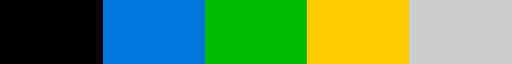

In [11]:
cmap = cm.nipy_spectral.resampled(5)
cmap

In [12]:
palette = cmap(np.linspace(0,1,6))

/tmp/ipykernel_1878237/1671639619.py:25: UserWarning:

FixedFormatter should only be used together with FixedLocator



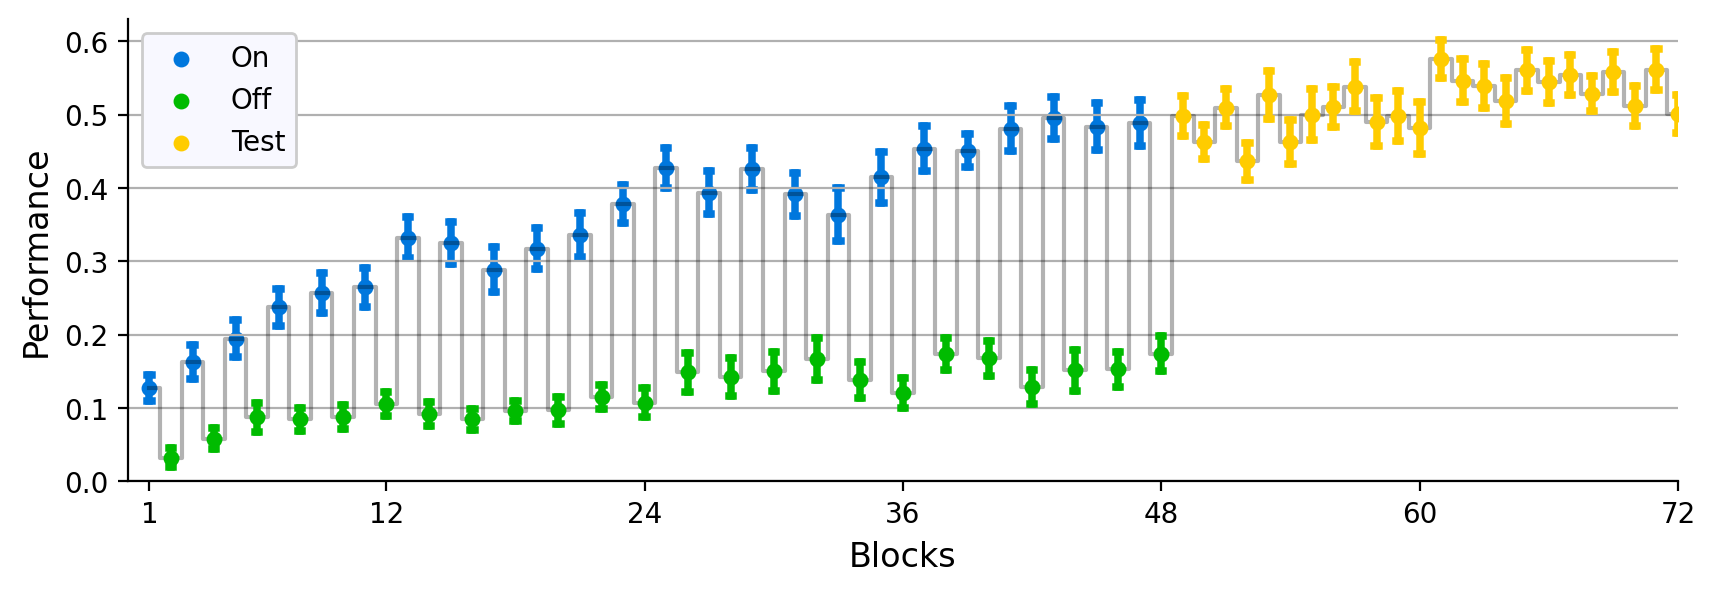

In [14]:
fig, ax = plt.subplots(figsize=(10,3))

## step line
ax = sns.lineplot(
    data=df_long,
    x="block", y="success_rate",
    color='k', drawstyle='steps-mid', alpha=0.3,
    errorbar=None,
    legend=False,
    ax=ax
)

ax = sns.pointplot(
    data=df_long,
    x="block", y="success_rate", hue="condition",
    join=False, palette=palette[1:4],
    markers='o', scale=.65,
    errorbar='se', capsize=0.2,
    ax=ax
)
ax.set(ylim=(0,0.63), xlim=(-1,71))
ax.set_xticks([0,11,23,35,47,59,71], minor=False)
ax.grid(axis='y')
ax.set_xticklabels(ax.get_xticks()+1, fontsize=10)
ax.set_yticklabels(['%.1f'%y for y in ax.get_yticks()], fontsize=10)
ax.set_ylabel('Performance', fontsize=12)
ax.set_xlabel('Blocks', fontsize=12)
ax.legend(
    ax.get_legend_handles_labels()[0], ['On', 'Off', 'Test']
    , loc='upper left'
    , fontsize=10
    , facecolor='ghostwhite', framealpha=1
)

sns.despine(bottom=False, left=False)

# fig.savefig(
#     join(dir_result, 'fig.1-c.png')
#     , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
# )

In [101]:
# fig = plt.figure(figsize=(5,5))
# gs = fig.add_gridspec(nrows=3, ncols=2)

# axs = []
# axs.append(fig.add_subplot(gs[:2,0]))
# axs.append(fig.add_subplot(gs[:2,1]))
# axs.append(fig.add_subplot(gs[2:,0:2]))

# ## ===================================================== ##

# for ii, nn in enumerate(['a','b','c']):       
#     ax = axs[ii]
#     ax.imshow(
#         mpimg.imread(join(dir_result, 'fig.1-%s.png'%nn))
#     )
#     ax.grid(None)
#     ax.axis('off')
#     ax.text(
#         0, 0, nn.upper(),
#         fontsize=18,
# #         fontweight='bold',
#         va='bottom', ha='right'
#     )

# ## ===================================================== ##
# fig.tight_layout(w_pad=0, h_pad=-8)

# # fig.savefig(
# #     '/home/sungbeenpark/Github/labs/GL/results/fig.1.png'
# #     , dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
# # )

## Paired T-test (r01 vs. r04)

In [126]:
# df_long.groupby(['subj','run']).mean()

In [15]:
### paired t-test
dt = pg.pairwise_tests(
    data=df_long[df_long.condition!='Test']
    , dv='success_rate'
    , subject='subj'
    , within=['condition','run']
    , alpha=0.05
    , effsize='eta-square'
)
dt

/home/sungbeenpark/.local/lib/python3.10/site-packages/pingouin/pairwise.py:478: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

/home/sungbeenpark/.local/lib/python3.10/site-packages/pingouin/pairwise.py:382: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

/home/sungbeenpark/.local/lib/python3.10/site-packages/pingouin/pairwise.py:383: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.iseti

,Contrast,condition,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,eta-square
0,condition,-,Off,On,True,True,-15.069654,23.0,two-sided,2.076039e-13,3.322e+10,0.621722
1,run,-,0,1,True,True,-5.714723,23.0,two-sided,8.070389e-06,2639.846,0.193424
2,run,-,0,2,True,True,-6.590236,23.0,two-sided,1.005637e-06,1.78e+04,0.331571
3,run,-,0,3,True,True,-9.714491,23.0,two-sided,1.316684e-09,8.566e+06,0.491787
4,run,-,1,2,True,True,-4.302931,23.0,two-sided,2.646336e-04,113.45,0.082726
5,run,-,1,3,True,True,-8.914011,23.0,two-sided,6.385179e-09,1.953e+06,0.226808
6,run,-,2,3,True,True,-4.034193,23.0,two-sided,5.167326e-04,62.691,0.036369
7,condition * run,Off,0,1,True,True,-2.078400,23.0,two-sided,4.901648e-02,1.321,0.036168
8,condition * run,Off,0,2,True,True,-3.580944,23.0,two-sided,1.582181e-03,23.49,0.134067
9,condition * run,Off,0,3,True,True,-4.493169,23.0,two-sided,1.646520e-04,173.179,0.186516


# two-way repeated measures ANOVA

In [16]:
tmp = df_long[df_long.condition!='Test'].groupby(['subj','run','condition','stage'], as_index=False).mean()
tmp

/tmp/ipykernel_1806534/3457781813.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,subj,run,condition,stage,success_rate
0,GL03,0,Off,early,0.063484
1,GL03,0,On,early,0.173843
2,GL03,1,Off,early,0.133333
3,GL03,1,On,early,0.463831
4,GL03,2,Off,late,0.111690
...,...,...,...,...,...
187,GL29,1,On,early,0.325752
188,GL29,2,Off,late,0.152778
189,GL29,2,On,late,0.467188
190,GL29,3,Off,late,0.236053


In [17]:
pg.rm_anova(
    data=tmp
    , dv='success_rate'
    , subject='subj'
    , within=['stage', 'condition']
    , correction=True
)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,stage,0.331046,1,23,0.331046,70.977481,1.745555e-08,1.745555e-08,0.270665,1.0
1,condition,1.319397,1,23,1.319397,227.094472,2.076039e-13,2.076039e-13,0.596625,1.0
2,stage * condition,0.068380,1,23,0.068380,101.821823,6.445622e-10,6.445622e-10,0.071198,1.0


---

## Off condition

In [18]:
tmp = df_long[df_long.condition=='Off'].groupby(['subj','stage'], as_index=False).mean()
tmp.set_index('subj', inplace=True)
tmp

/tmp/ipykernel_1806534/2823774554.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,stage,success_rate,run
subj,,,
GL03,early,0.098409,0.5
GL03,late,0.163281,2.5
GL04,early,0.159896,0.5
GL04,late,0.170255,2.5
GL05,early,0.067766,0.5
GL05,late,0.076794,2.5
GL06,early,0.055787,0.5
GL06,late,0.110706,2.5
GL07,early,0.032668,0.5


<AxesSubplot: xlabel='stage', ylabel='success_rate'>

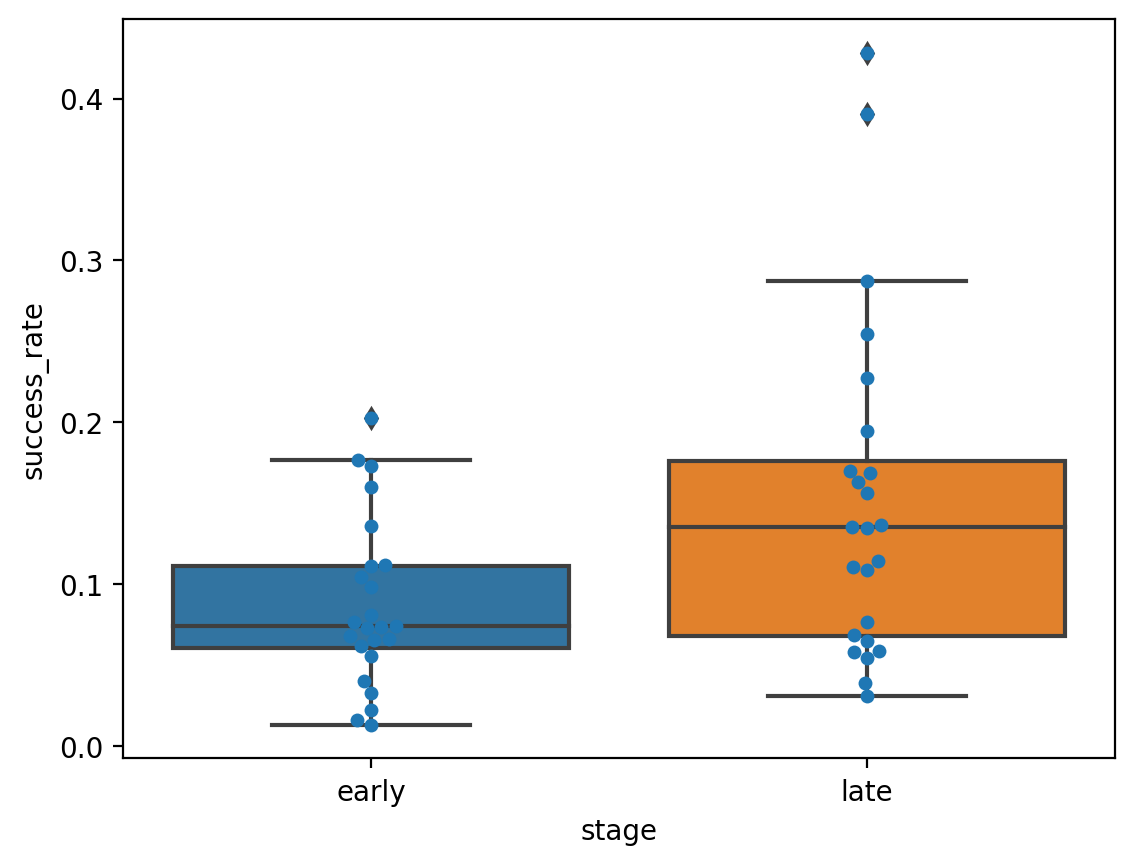

In [19]:
g = sns.boxplot(
    data=tmp, x='stage', y='success_rate'
)
sns.swarmplot(
    data=tmp, x='stage', y='success_rate'
)

In [20]:
for ii, x1 in enumerate(g.get_xticklabels()):
    xx1 = x1.get_text()
    a = tmp[tmp.stage==xx1].success_rate
    for jj, x2 in enumerate(g.get_xticklabels()[ii+1:]):
        xx2 = x2.get_text()
        b = tmp[tmp.stage==xx2].success_rate
        tval, pval = stats.ttest_rel(a,b)
        print('%s vs. %s: t=%.4f, %.4f(%s)'%(xx1,xx2,tval,pval,convert_pvalue_to_asterisks(pval)))

early vs. late: t=-4.3691, 0.0002(***)


---

## Test session

In [21]:
tmp = df_long.groupby(['subj','condition','run','stage'], as_index=False).mean()
tmp

/tmp/ipykernel_1806534/285687068.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,subj,condition,run,stage,success_rate
0,GL03,Off,0,early,0.063484
1,GL03,Off,1,early,0.133333
2,GL03,Off,2,late,0.111690
3,GL03,Off,3,late,0.214873
4,GL03,On,0,early,0.173843
...,...,...,...,...,...
235,GL29,On,1,early,0.325752
236,GL29,On,2,late,0.467188
237,GL29,On,3,late,0.478125
238,GL29,Test,0,early,0.409954


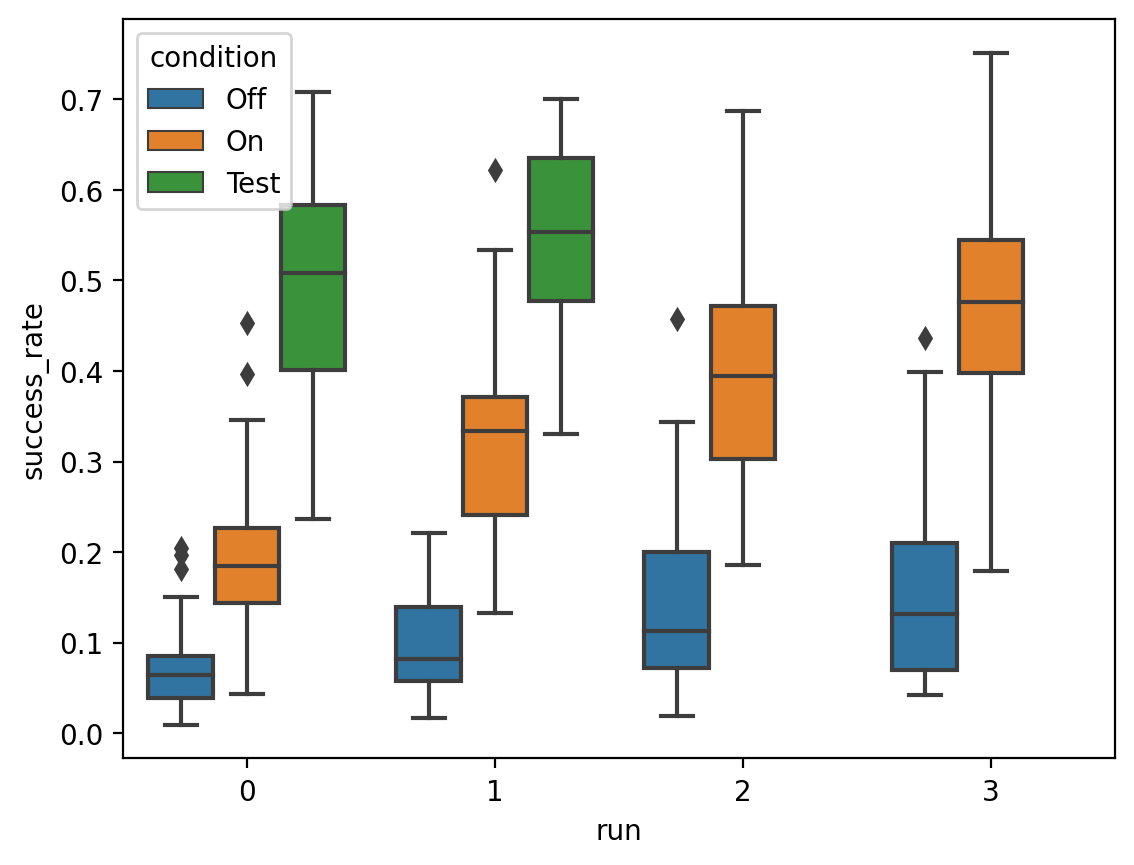

In [26]:
g = sns.boxplot(
    data=tmp, x='run', y='success_rate', hue='condition'
)
# sns.swarmplot(
#     data=tmp, x='stage', y='success_rate', hue='condition'
# )

In [22]:
a = tmp[(tmp.condition=='On')&(tmp.run==3)].success_rate
b = tmp[(tmp.condition=='Test')&(tmp.run==0)].success_rate
tval, pval = stats.ttest_rel(a,b)
print('T(1,%d)=%.4f, p=%.4f(%s)'%(len(a)-1,tval,pval,convert_pvalue_to_asterisks(pval)))

T(1,23)=-0.7656, p=0.4517(ns)
